In [91]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import torch.nn as nn
import math
from tqdm import tqdm
import numpy as np

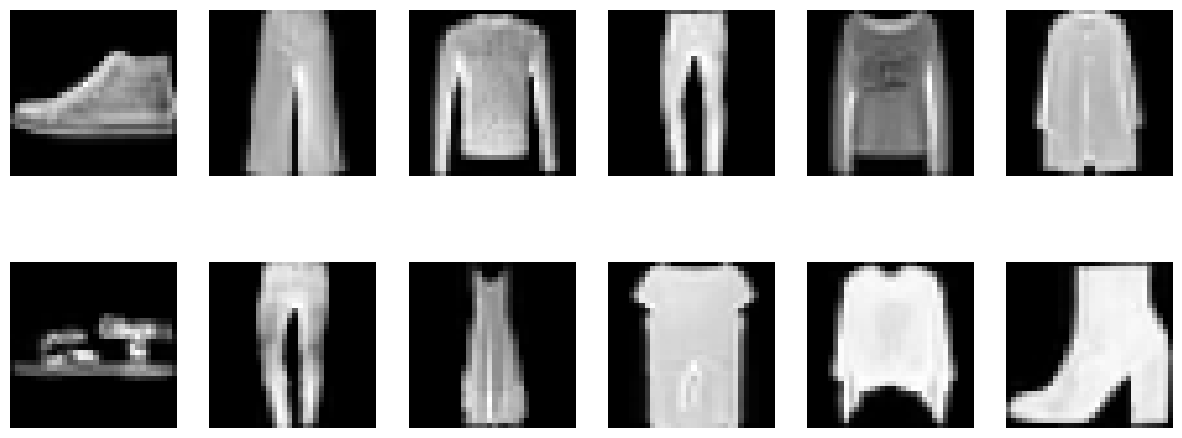

In [254]:
def load_fashion_mnist_dataset(img_size, n_samples, batch_size):
    # Define transformation: resize and scale to [-1, 1]
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])  # maps [0,1] to [-1,1] for grayscale
    ])

    # Download and load the Fashion-MNIST dataset
    dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

    # Limit the number of samples
    if n_samples is not None and n_samples < len(dataset):
        dataset, _ = random_split(dataset, [n_samples, len(dataset) - n_samples])

    # Create DataLoader
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

import matplotlib.pyplot as plt

def show_images(images, img_size, n_to_show=5, cols_per_row=3):
    images = images / 2 + 0.5
    n_rows = (n_to_show + cols_per_row - 1) // cols_per_row  # Calculate the number of rows needed
    
    plt.figure(figsize=(15, 3 * n_rows))  # Adjust the size of the figure based on the number of rows
    for i, img in enumerate(images):
        if i >= n_to_show:
            break

        plt.subplot(n_rows, cols_per_row, i + 1)  # Arrange images in multiple rows and columns
        plt.imshow(img.squeeze().cpu().detach(), cmap='gray')  # Use squeeze() for grayscale images
        plt.axis('off')
    plt.show()

# Parameters
img_size = 32  # Resize to 32x32, or keep 28x28 as per your requirement
n_samples = 20_000
batch_size = 128

# Load the dataset
dataloader = load_fashion_mnist_dataset(img_size, n_samples, batch_size)

# Get some random training images
dataiter = iter(dataloader)
images, labels = next(dataiter)

# Display images
show_images(images, img_size, n_to_show=12, cols_per_row = 6)

In [93]:
device = torch.device("cuda")

In [136]:
T = 1000

betas = torch.linspace(1e-4, 0.02, T).to(device)
sqrt_betas = torch.sqrt(betas)
alphas = 1 - betas
inv_sqrt_alphas = 1.0 / torch.sqrt(alphas)

a_bars = torch.cumprod(alphas, dim=0)
sqrt_a_bars = torch.sqrt(a_bars)
sqrt_one_minus_a_bars = torch.sqrt(1.0 - a_bars)
inv_sqrt_one_minus_alpha_bars = 1.0 / sqrt_one_minus_a_bars

In [95]:
# horrible name i know
def get_as_value_images(scalar_list, batched_times):
    
    B = len(batched_times)
    
    return scalar_list[batched_times].view(B, 1).unsqueeze(2).unsqueeze(3)

In [213]:
def forward(X, t):
    
    # returns noise and noisy picture (the picture at t + 1)
    
    epsilon = torch.randn_like(X).to(device)
    
    sqrt_a_bars_t = get_as_value_images(sqrt_a_bars, t)
    
    sqrt_one_minus_a_bars_t = get_as_value_images(sqrt_one_minus_a_bars, t)
    
    noisy_images = (sqrt_a_bars_t * X) + (sqrt_one_minus_a_bars_t * epsilon)
    
    return noisy_images, epsilon

In [214]:
class UNetBlock(nn.Module):
    
    # the time_emb_dim stays the same (is defined in the UNet, single number like t = 5 gets a 32-dim vector for example)
    
    def __init__(self, in_channels, out_channels, time_emb_dim, up=False):
        
        super().__init__()
        
        # no resize but convolution gets done afterwards
        # kernel size = 3, padding = 1 (we don't change the dimensions)
        # if we don't specify anything, stride = 1
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        
        # every outchannel needs to be aware of the time...
        self.time_trafo = nn.Linear(time_emb_dim, out_channels)
        
        if up:
            # local computation to work in the residual connections
            self.conv1 = nn.Conv2d(2 * in_channels, out_channels, 3, padding=1)
            # upsampling (but not UpSample [the reverse to MaxPool])
            self.transform = nn.ConvTranspose2d(out_channels, out_channels, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
            # downsampling
            self.transform = nn.Conv2d(out_channels, out_channels, 4, 2, 1)
            
        # image -> conv1 -> relu -> batch -> conv2 -> relu -> batch -> transform [image dimensions change]
        
        self.batch1 = nn.BatchNorm2d(out_channels)
        self.batch2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        
        self.to(device)
        
    def forward(self, X, t):
        
        time_embedding_this_block = self.relu(self.time_trafo(t))
        
        # time embedding = same number as out channels
        time_embedding_this_block = time_embedding_this_block.unsqueeze(2).unsqueeze(3)
                        
        X = self.conv1(X)
        X = self.relu(X)
        X = self.batch1(X)
        
        # X has out_channels so we can finally add the time embedding
        X = X + time_embedding_this_block
        
        X = self.conv2(X)
        X = self.relu(X)
        X = self.batch2(X)
        
        return self.transform(X)

In [215]:
# in Transfomers you can learn the embeddings (scalar to vector of size dim)
# with nn.Embedding
# this can be done as well (no learning but the rows are clearly distringuisable because of the varying freqs)

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        
        self.to(device)

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings

In [216]:
class UNet(nn.Module):
    
    # the time_emb_dim stays the same ()
    def __init__(self, img_channels):
        
        super().__init__()
        
        # 32 -> 16 -> 8
        down = [64, 128, 256, 512]
        up = [512, 256, 128, 64]
        self.n_steps = len(down)
        
        # a scalar (the time t = 5 for example) gets a 32-dimensional vector (like in Transformers)
        time_emb_dim = 64
        
        self.time_embedding = nn.Sequential(
            SinusoidalPositionEmbeddings(dim = time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )
        
        self.first_conv = nn.Conv2d(img_channels, down[0], 3, padding=1)
        
        self.down_blocks = [UNetBlock(down[i], down[i + 1], time_emb_dim) for i in range(len(down)-1)]
        
        self.encoder = nn.ModuleList(self.down_blocks)
        
        self.up_blocks = [UNetBlock(up[i], up[i + 1], time_emb_dim, up=True) for i in range(len(up)-1)]

        self.decoder = nn.ModuleList(self.up_blocks)
        
        self.last_conv = nn.Conv2d(up[-1], img_channels, 1)
        
        self.to(device)
        
    def forward(self, X, t):
        
        # list of scalars [15, 3, 8, 4] to list of rows with row = 32-dimensional vector
        t = self.time_embedding(t)
        
        # TODO: don't forget positional embedding
        residuals = []
        
        curr = self.first_conv(X)
                        
        for i in range(self.n_steps - 1):
            
            curr = self.encoder[i](curr, t)
            
            residuals.append(curr)
            
        for i in range(self.n_steps - 1):
            
            res_input = residuals.pop()
            
            curr = self.decoder[i](torch.cat((curr, res_input), dim=1), t)
            
        curr = self.last_conv(curr)
        
        return curr

In [217]:
def get_noisy_images(X):
    
    # every picture gets a different amount of noise
    B = X.shape[0]
    t = torch.randint(1, T, (B, ), device=device).long()
        
    noisy_images, epsilons = forward(X, t)
    
    return noisy_images, epsilons, t

In [218]:
mse = nn.MSELoss()

def loss(model, noisy_images, epsilons, t):
    
    noise_predictions = model(noisy_images, t)
    
    return mse(epsilons, noise_predictions)

In [219]:
unet = UNet(img_channels = 1)

In [220]:
optim = torch.optim.Adam(unet.parameters(), lr=1e-4)

In [244]:
n_epochs = 15

for epoch_idx in range(n_epochs):
    
    batch_losses = []
    
    for X_batch, _ in tqdm(dataloader):
        
        X_batch = X_batch.to(device)
        
        noisy_images, epsilons, t = get_noisy_images(X_batch)
        
        l_batch = loss(unet, noisy_images, epsilons, t)
        
        batch_losses.append(l_batch.item())
        
        optim.zero_grad()
        l_batch.backward()
        optim.step()
    
    epoch_loss = np.mean(np.array(batch_losses))
    
    print(f"{epoch_idx +  1}. loss = {epoch_loss}")

100%|█████████████████████████████████████████| 157/157 [00:16<00:00,  9.45it/s]


1. loss = 0.04038799683426975


100%|█████████████████████████████████████████| 157/157 [00:16<00:00,  9.46it/s]


2. loss = 0.03832346719399


100%|█████████████████████████████████████████| 157/157 [00:16<00:00,  9.45it/s]


3. loss = 0.037248520429726616


100%|█████████████████████████████████████████| 157/157 [00:16<00:00,  9.43it/s]


4. loss = 0.03520232157864768


100%|█████████████████████████████████████████| 157/157 [00:16<00:00,  9.43it/s]


5. loss = 0.034362323594036376


100%|█████████████████████████████████████████| 157/157 [00:16<00:00,  9.43it/s]


6. loss = 0.03458072503755806


100%|█████████████████████████████████████████| 157/157 [00:16<00:00,  9.43it/s]


7. loss = 0.0347852336871586


100%|█████████████████████████████████████████| 157/157 [00:16<00:00,  9.42it/s]


8. loss = 0.03269194257534613


100%|█████████████████████████████████████████| 157/157 [00:16<00:00,  9.42it/s]


9. loss = 0.03250319458496798


100%|█████████████████████████████████████████| 157/157 [00:16<00:00,  9.42it/s]


10. loss = 0.031824424815405705


100%|█████████████████████████████████████████| 157/157 [00:16<00:00,  9.42it/s]


11. loss = 0.030663966076673977


100%|█████████████████████████████████████████| 157/157 [00:16<00:00,  9.43it/s]


12. loss = 0.03070546836135494


100%|█████████████████████████████████████████| 157/157 [00:16<00:00,  9.42it/s]


13. loss = 0.03162642927828488


100%|█████████████████████████████████████████| 157/157 [00:16<00:00,  9.43it/s]


14. loss = 0.030709782223792594


100%|█████████████████████████████████████████| 157/157 [00:16<00:00,  9.42it/s]

15. loss = 0.030747959473330505


In [245]:
@torch.no_grad()
def sample_from_model(model, img_size, num_samples):
    
    curr = torch.randn((num_samples, 1, img_size, img_size)).to(device)
    
    model.eval()
    for t in tqdm(reversed(range(0, T))):
        
        if t > 0:
            z = torch.randn((num_samples, 1, img_size, img_size)).to(device)
            
        else:
            z = 0
            
        t_tensor = torch.tensor([t] * num_samples).long().to(device)
                    
        noise_preds = model(curr, t_tensor)
        
        inv_sqrt_alpha_t = get_as_value_images(inv_sqrt_alphas, t_tensor)
        inv_sqrt_one_minus_alpha_bar_t = get_as_value_images(inv_sqrt_one_minus_alpha_bars, t_tensor)
        beta_t = get_as_value_images(betas, t_tensor)
        sigma_t = get_as_value_images(sqrt_betas, t_tensor)

        
        model_mean = inv_sqrt_alpha_t * (curr - (beta_t * inv_sqrt_one_minus_alpha_bar_t) * noise_preds)
        
        # denoise one step 
        curr = model_mean + sigma_t * z
        
    curr = torch.clamp(curr, min=-1, max=1)
    
    model.train()
    return curr

In [250]:
gens = sample_from_model(model = unet, img_size = img_size, num_samples = 50)

1000it [00:14, 68.17it/s]


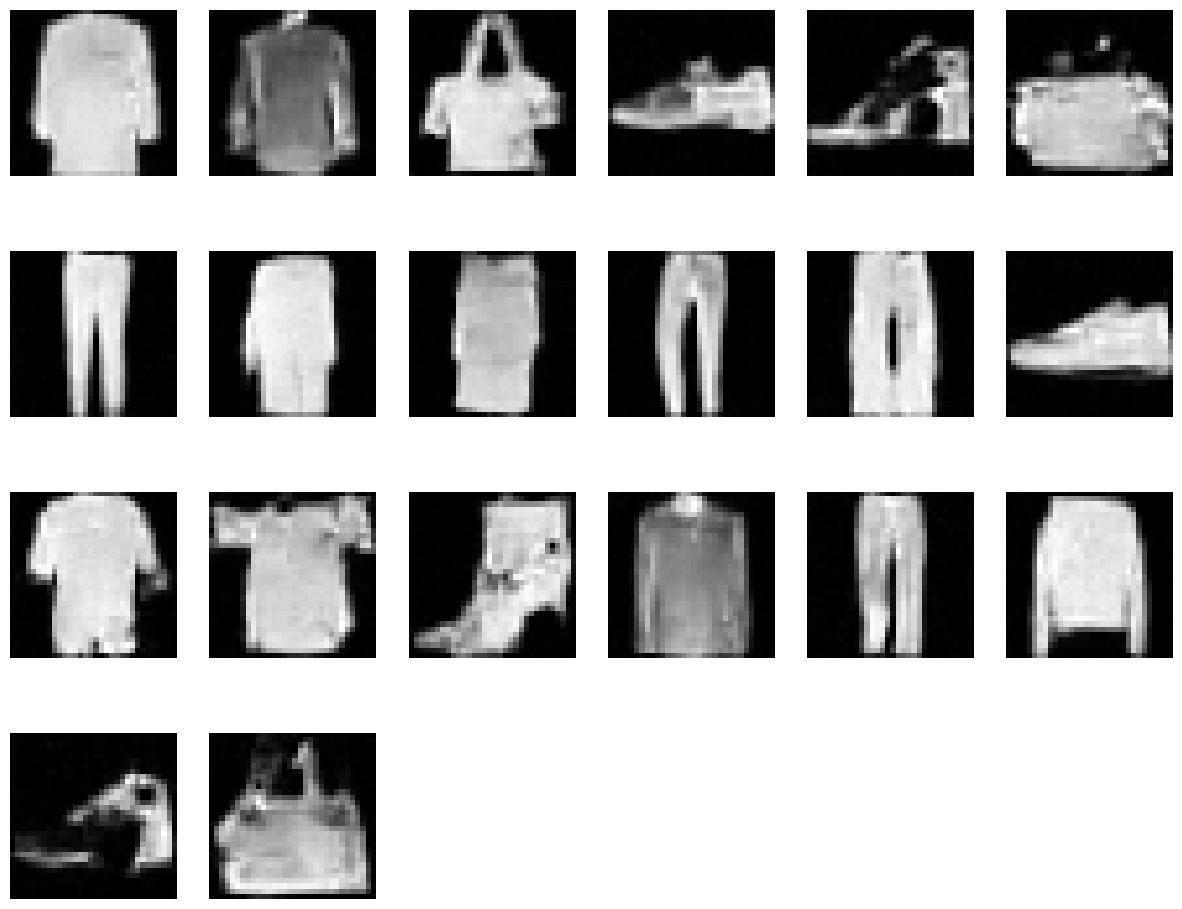

In [253]:
show_images(gens, img_size, n_to_show = 20, cols_per_row = 6)

In [255]:
torch.save(unet.state_dict(), 'unet.pth')